# Graph Hilbert Transform

In [2]:
import sys
import importlib

sys.path.append("../")

from src.utils import *

from src import operations
from src import graph_utils
from src import jordanzero_destroy

import scienceplots
plt.style.use(['science','ieee', 'no-latex'])

# for better visualisation of graphs. Comment out if not needed
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['figure.figsize'] = [3, 2]

## Description

Reproducing Figures in 10.1109/LSP.2025.3560170

In [3]:
path_data = '../resources/'

## Simple Example

Method chosen is: eig


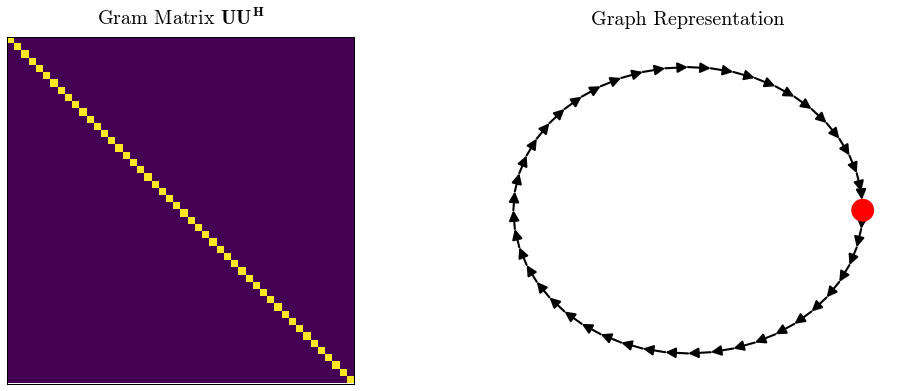

In [13]:
# Making cycle graph
N = 48
cycle = graph_utils.make_graph(N, graph_type="cycle")

N = cycle.shape[0]
L, U, V, Uinv, S, J, Sinv = graph_utils.prep_transform(cycle, gso="laplacian")

G, pos = graph_utils.vis_graph(cycle, U, 0)

dirac_signal = np.ones(N) * 0
dirac_signal[0] = 5

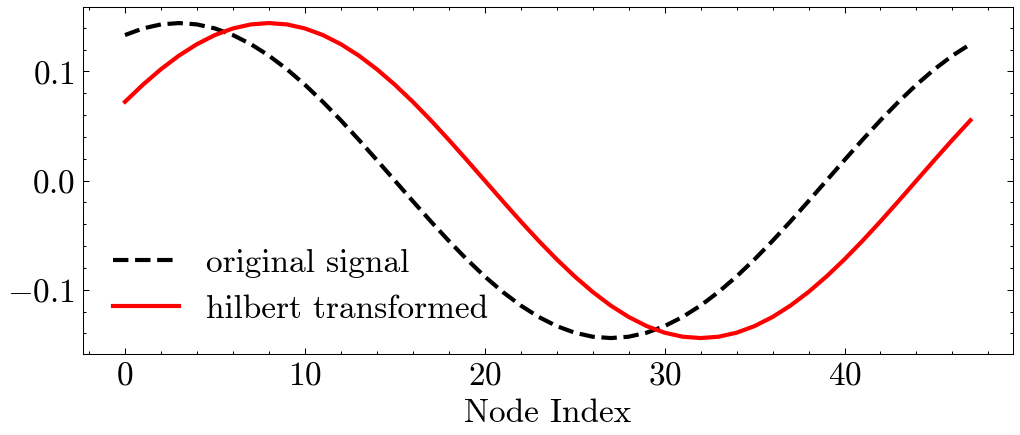

In [14]:
fig, ax = plt.subplots(1, figsize=(8,3))

ax.plot(U[:, 2].real, label="original signal", c="k", linestyle="--", linewidth=2)
ax.plot((operations.hilbert_transform(U[:, 2].real, U, V) * 1j).imag[::-1], label="hilbert transformed", c="r", linewidth=2)
ax.set_xlabel("Node Index", fontsize=16)
ax.legend(prop={"size": 16})
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=16)

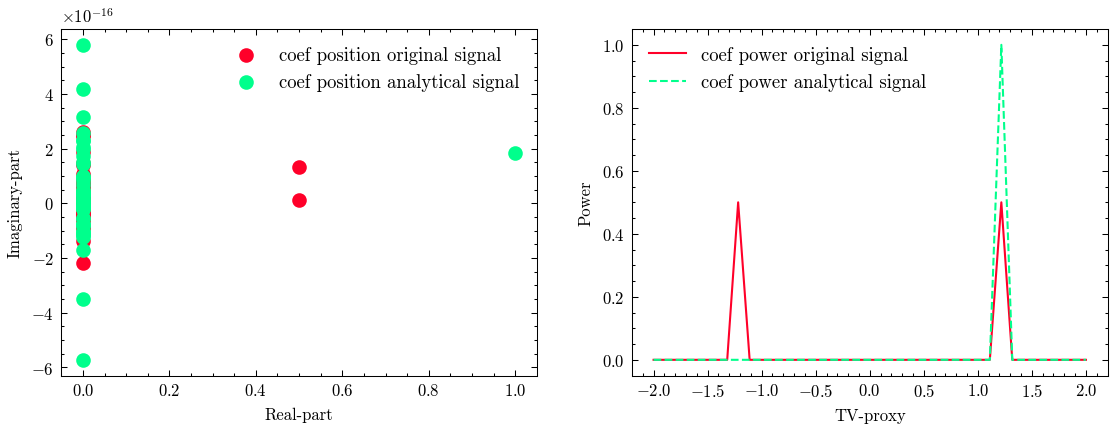

In [15]:
graph_utils.plot_spectrum_gft([U[:, 20].real, operations.analytical_signal(U[:, 20].real, U, V)],
                            U, V, Uinv=None, labels=["original signal", "analytical signal"])

## Figures reproduction


### Fig 1: Rosace

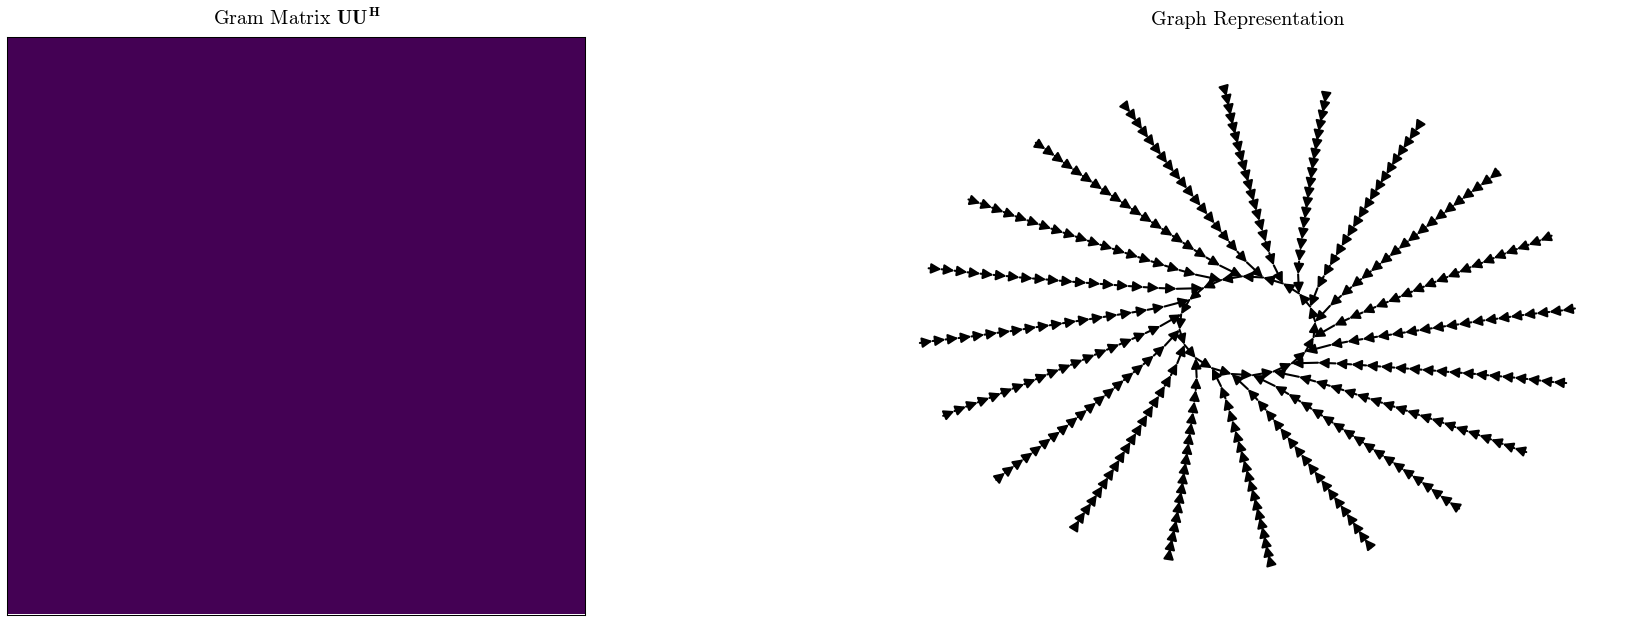

In [17]:
Nr = 20
cycle = graph_utils.make_graph(Nr, graph_type="cycle")
Nc = 20
A = np.zeros((Nc * Nr, Nc * Nr))
for k in range(Nc):
    tmp = deepcopy(cycle)
    if k in np.arange(Nc):
        tmp[-1][0] = 0
    A[k * Nr : (k + 1) * Nr, k * Nr : (k + 1) * Nr] = tmp
    if k + 1 == Nc:
        A[0, k * Nr] = 1
    else:
        A[(k + 1) * Nr, k * Nr] = 1

G, pos = graph_utils.vis_graph(A, np.zeros((Nr, Nr)), -1, figsize=(15, 5))

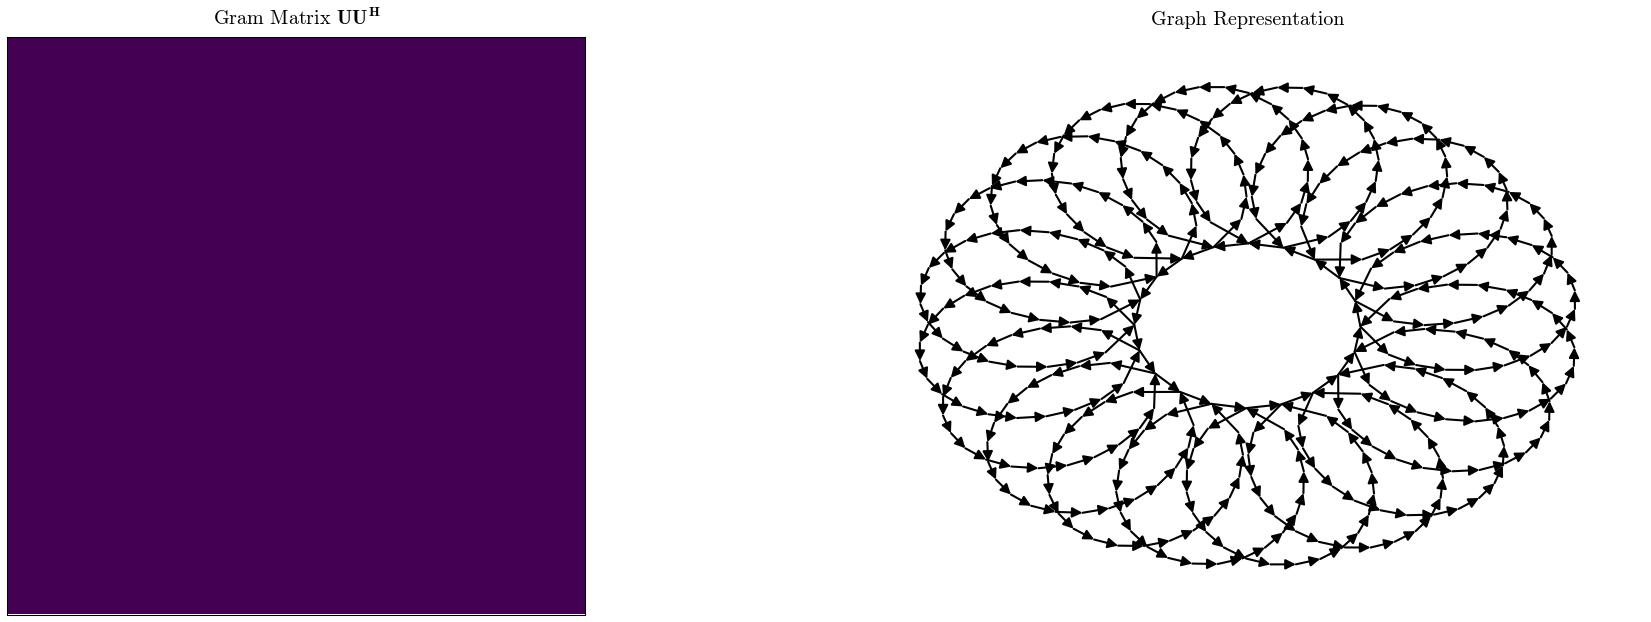

Method chosen is: eig


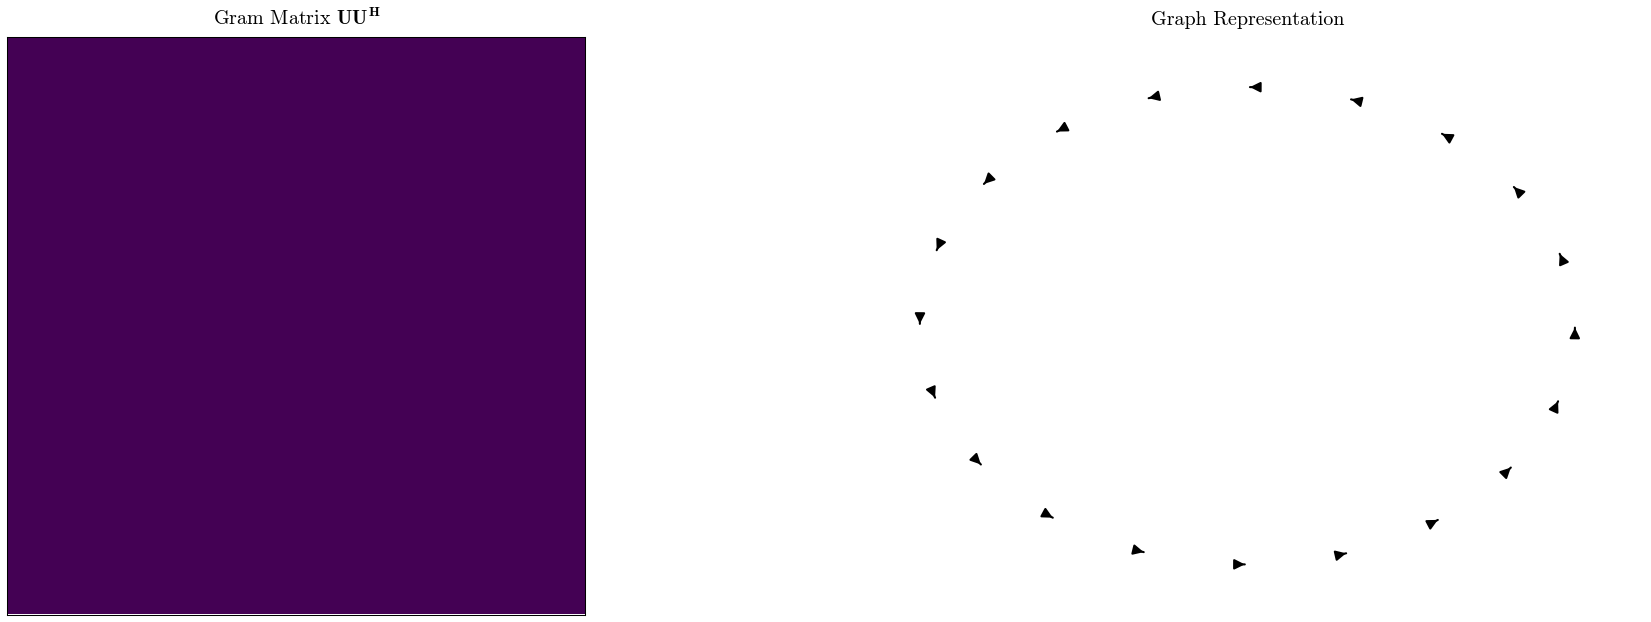

In [19]:
newA = jordanzero_destroy.destroy_jordan_blocks(A, prefer_nodes=[0 + Nr * k for k in range(Nc)])
_, _ = graph_utils.vis_graph(newA, np.zeros((Nr, Nr)), -1, figsize=(15, 5))

N = newA.shape[0]
L, U, V, Uinv, S, J, Sinv = graph_utils.prep_transform(newA, gso="adj")
Gnew, _ = graph_utils.vis_graph(np.abs(newA-A), np.zeros((Nr, Nr)), -1, figsize=(15, 5))

In [20]:
circle = np.linspace(0,2*np.pi, Nr)
# frequencies = [(k+5)/30*np.pi for k in range(Nc)]
frequencies = [(k/2) for k in range(Nc)]
phase = [(Nc+1 - .2)/2*np.pi/Nc * k for k in range(Nc)]
graphsig = np.concatenate([(2*v+1) * np.sin(freq * circle + phase[v]) for v, freq in enumerate(frequencies)])

xa = operations.analytical_signal(graphsig, U, V, Uinv=Uinv)
hx = operations.hilbert_transform(graphsig, U, V, Uinv=Uinv)
amp = np.abs(xa)
ang = np.arctan2(xa.imag, xa.real)

Fig 1.b/c

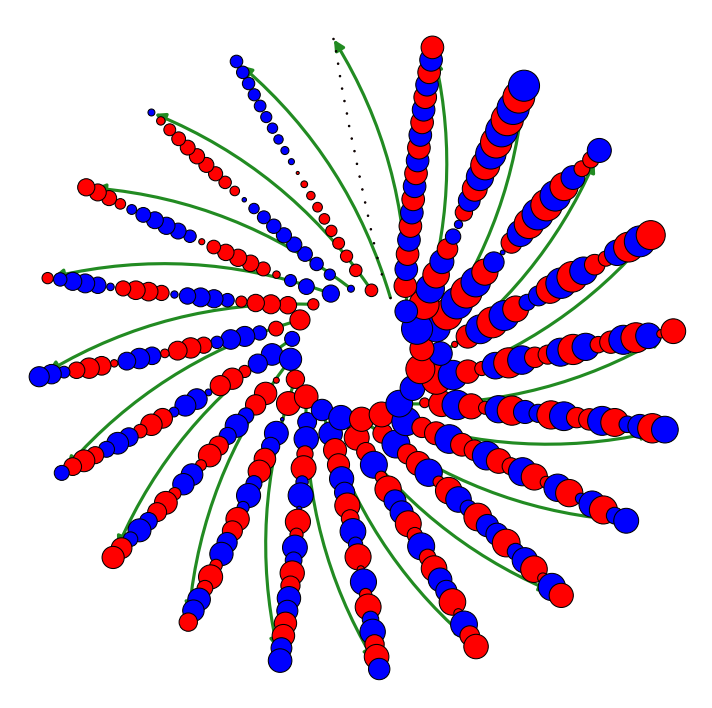

In [25]:
from matplotlib.lines import Line2D

scolor = ["red", "blue"]
scale = 16

nd_values = graphsig + 1e-2
nd_color = [scolor[0] if nd > 0 else scolor[1] for nd in nd_values]
node_values = scale * np.abs(nd_values) ** (6/8)

fig, ax = plt.subplots(1, figsize=(6, 6))

nx.draw_networkx_nodes(G, pos, alpha=1, node_size=node_values, node_color=nd_color, cmap=None, ax=ax, edgecolors='black', linewidths=0.5)
nx.draw_networkx_edges(Gnew, pos, alpha=1, node_size=node_values, ax=ax, edge_color="forestgreen", 
                       width=1.5, connectionstyle="arc3,rad=0.15", label='Added Edges')
# nx.draw_networkx_edges(Gnew, pos, alpha=1, ax=ax, edge_color="red", label='Added Edges')

handles = [Line2D([], [], color=color, label=label)
           for color, label in zip(["Red"], ["Added Edges"])]

# ax.legend(handles=handles, prop={'size':30, 'family':'Helvetica'}, loc=(0.05,-.15))

plt.autoscale(enable=True, axis='x', tight=True)
plt.autoscale(enable=True, axis='y', tight=True)
plt.axis('off')
# fig.savefig('../figure_resources/rosace-original-signal.png', dpi=300)
plt.show()

### Fig 2.a/b/c

/var/folders/9t/60tqjhtx2h55525lstv8nsc40000gn/T/ipykernel_45439/1830561748.py:76: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([r'$0$', r'$5$', r'$10$', r'$15$', r'$20$'], **hfont)


Text(0, 0.5, '$\\varphi({\\bf x})[k]$')

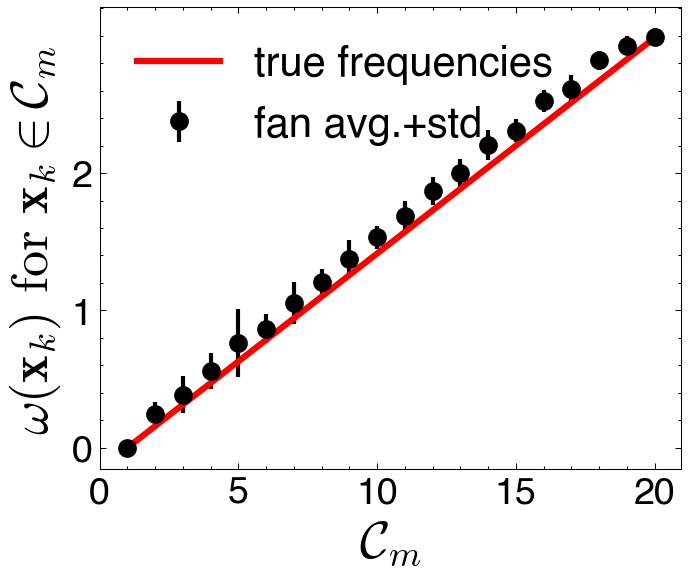

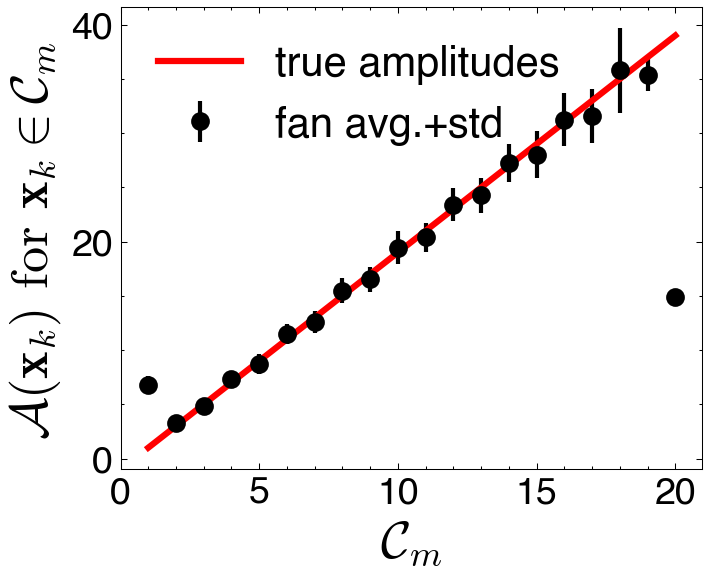

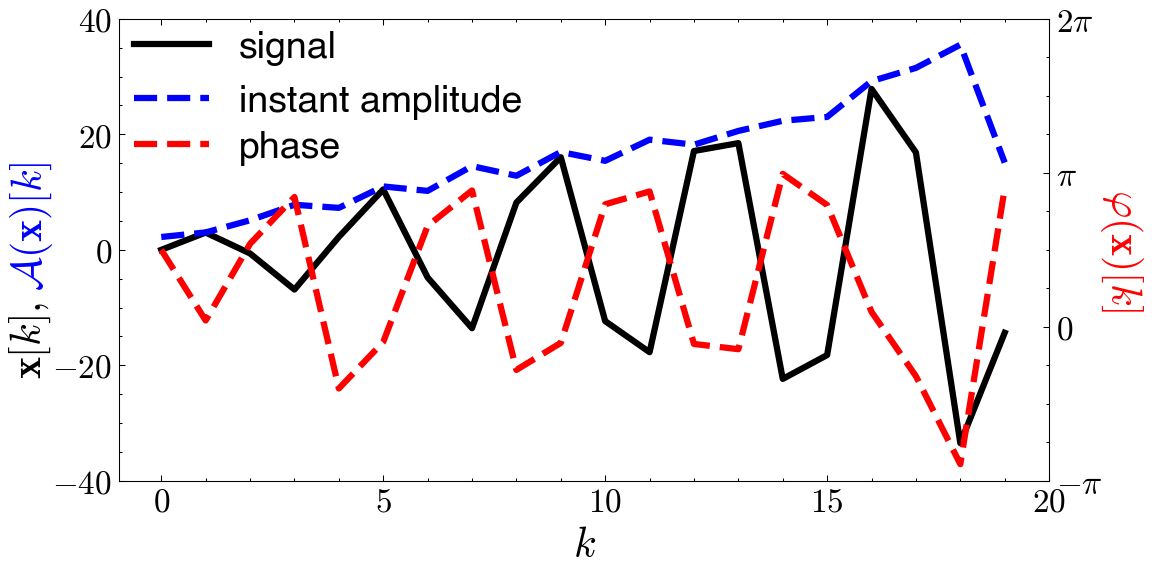

In [26]:
from matplotlib.offsetbox import AnchoredOffsetbox, TextArea, HPacker, VPacker

# freqs
unwraped = [np.zeros(Nr)] + [np.unwrap(ang[np.arange(0+k*Nr,Nr+k*Nr)]) for k in range(1,Nc)]

freqs_est = [np.concatenate([np.abs(np.diff(unwraped[k])), [np.abs(np.diff(unwraped[k])).mean()]]) for k in range(Nc)]
freqs_est_mean = [np.abs(np.diff(unwraped[k])).mean() for k in range(Nc)]

# amps
amps_cycle = [amp[np.arange(0+k*Nr,Nr+k*Nr)] for k in range(Nc)]

hfont = {'fontname':'Helvetica'}

unwrap_ang_center = np.unwrap(ang[np.arange(0,Nr*Nc,Nr)])
freq_center = np.abs(np.diff(unwrap_ang_center, append=unwrap_ang_center[-1]))
amp_center = amp[np.arange(0,Nr*Nc,Nr)]

fig, ax = plt.subplots(1, figsize=(5,4))

freqs_est = np.array(freqs_est)

ax.errorbar(np.arange(1,Nc+1), freqs_est.mean(axis=1), yerr=freqs_est.std(axis=1)/2, linestyle='', label='fan avg.+std', marker='o', markersize=8, linewidth=2)

ax.plot(np.arange(1,Nc+1), np.array(frequencies)/Nr * 2 * np.pi, linestyle='solid', label='true frequencies', linewidth=3)

ax.set_ylabel(r"$\omega({\bf x}_k)$ for ${\bf x}_k\in{\mathcal{C}}_m$ ", size=25)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.set_xticks(np.arange(0,Nc+1,5))
ax.set_xticklabels(np.arange(0,Nc+1,5), **hfont)
ax.set_xlabel(r"$\mathcal{C}_m$", size=25)

ax.set_yticks(np.arange(0,3))
ax.set_yticklabels(np.arange(0,3), **hfont)
ax.legend(prop={'size':20, 'family':'Helvetica'})
# fig.savefig('../figure_resources/flower-instant-frequencies.png', dpi=300)

amps_cycle = np.array(amps_cycle)
fig, ax = plt.subplots(1, figsize=(5,4))
ax.errorbar(np.arange(1,Nc+1), amps_cycle.mean(axis=1), yerr=amps_cycle.std(axis=1)/2, linestyle='', label='fan avg.+std', marker='o', markersize=8, linewidth=2)
ax.plot(np.arange(1,Nc+1), [(2*v+1) for v in range(Nc)], linestyle='solid', label='true amplitudes', linewidth=3)
ax.set_ylabel(r"$\mathcal{A}({\bf x}_k)$ for ${\bf x}_k\in{\mathcal{C}}_m$ ", size=25)

ax.tick_params(axis='both', which='major', labelsize=18)
ax.set_xticks(np.arange(0,Nc+1,5))
ax.set_xticklabels(np.arange(0,Nc+1,5), **hfont)
ax.set_xlabel(r"$\mathcal{C}_m$", size=25)

ax.set_yticks(np.arange(0,42, 20))
ax.set_yticklabels(np.arange(0,41, 20), **hfont)
ax.legend(prop={'size':20, 'family':'Helvetica'})

# fig.savefig('../figure_resources/flower-instant-amplitude.png', dpi=300)


fig, ax = plt.subplots(1, figsize=(8,4))

ax2 = ax.twinx()
ax.plot(graphsig[np.arange(0,Nr*Nc,Nr)], label='signal', linewidth=3)
ax.plot(amp_center, label='instant amplitude', color='b', linewidth=3)
ax2.plot(ang[np.arange(0,Nr*Nc,Nr)], label='phase', color='r', linestyle='--', linewidth=3)


ybox1 = TextArea(r"${\bf x}[k], $", textprops=dict(color="k", size=20,rotation=90,ha='left',va='bottom'))
ybox2 = TextArea(r"$\mathcal{A}{{\bf (x})}[k]$", textprops=dict(color="b", size=20,rotation=90,ha='left',va='bottom'))

ybox = VPacker(children=[ybox2, ybox1],align="bottom", pad=0, sep=5)

anchored_ybox = AnchoredOffsetbox(loc=6, child=ybox, pad=0., frameon=False, bbox_to_anchor=(-0.12, 0.43), 
                                  bbox_transform=ax.transAxes, borderpad=0.)

ax.add_artist(anchored_ybox)

ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xticks(np.arange(0,Nc+1,5))
# ax.set_xticklabels(np.arange(0,Nc+1,5), **hfont)
ax.set_yticklabels([r'$0$', r'$5$', r'$10$', r'$15$', r'$20$'], **hfont)

ax.set_yticks(np.arange(-40,41, 20))
ax.set_yticklabels([r'$-40$', r'$-20$', r'$0$', r'$20$', r'$40$'], **hfont)
ax2.set_yticks(np.arange(-np.pi, 7, np.pi))
ax2.set_yticklabels([r'$-\pi$', r'$0$', r'$\pi$', r'$2\pi$'], **hfont)

ax2.tick_params(axis='both', which='major', labelsize=16)
ax.legend(prop={'size':18, 'family':'Helvetica'}, loc=(0,0.75))
ax2.legend(prop={'size':18, 'family':'Helvetica'}, loc=(0,0.65))
ax.set_xlabel(r'$k$', size=20, **hfont)
ax2.set_ylabel(r"$\varphi({\bf x})[k]$", size=20, rotation=270, labelpad=20, color='red')
# fig.savefig('../figure_resources/central-cycle-instants.png', dpi=300)

### Fig 3: Lattice

Method chosen is: eig


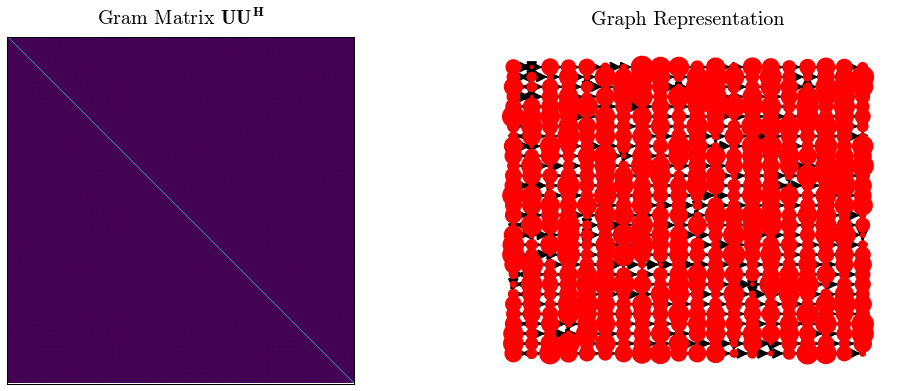

In [29]:
Nr, Nc = 20, 30
tor = graph_utils.make_graph((Nr, Nc), 'torus')
N = tor.shape[0]
L, U, V, Uinv, _, _, _ = graph_utils.prep_transform(tor, gso="adj")

pos = {k: (-k % Nr, k // Nr) for k in range(0, Nr * Nc)}

G, pos = graph_utils.vis_graph(tor, U, pos=pos)

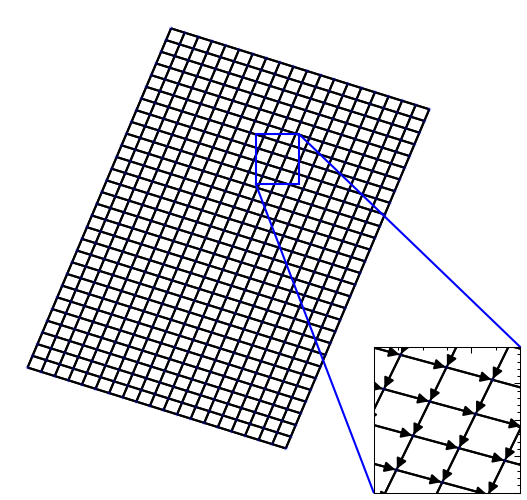

In [30]:
theta = np.radians(160)  # rotate 180 degrees
rot_matrix = np.array([[np.cos(theta), -np.sin(theta)],
                       [np.sin(theta), np.cos(theta)]])

coords = np.array(list(pos.values()))
rotpos = (rot_matrix @ coords.T).T
rotpos = {k: rotpos[k] for k in range(len(rotpos))}

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset, inset_axes

nodesize = 1
fig, ax = plt.subplots(1, figsize=(4.2, 4.2))

Gund = nx.from_numpy_array(tor.astype(int), create_using=nx.Graph())
# Gund_added = nx.from_numpy_array(np.abs(newA - adj), create_using=nx.MultiGraph())
nx.draw_networkx_nodes(G, rotpos, alpha=0.2, node_size=nodesize, node_color=np.ones(U.shape[0]), cmap="winter", ax=ax)
nx.draw_networkx_edges(Gund, rotpos, node_size=nodesize, alpha=1, ax=ax, edge_color="black", width=1)
# nx.draw_networkx_edges(Gund_added, pos, node_size=nodesize, alpha=0.7, ax=ax, edge_color="forestgreen", width=0.4)

x1, x2, y1, y2 = -12, -9, -6, -2
axins = ax.inset_axes(
    [0.75, 0, 0.3, 0.3],
    xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])

Gund = nx.from_numpy_array(tor.astype(int), create_using=nx.DiGraph())
# Gund_added = nx.from_numpy_array(np.abs(newA - adj), create_using=nx.DiGraph())

nx.draw_networkx_nodes(G, rotpos, alpha=0.2, node_size=nodesize, node_color=np.ones(U.shape[0]), cmap="winter", ax=axins)
nx.draw_networkx_edges(Gund, rotpos, node_size=nodesize, alpha=1, ax=axins, edge_color="black", width=1)
# nx.draw_networkx_edges(Gund_added, pos, node_size=nodesize, alpha=0.5, ax=axins, edge_color="forestgreen", width=0.4)

ax.indicate_inset_zoom(axins, edgecolor="blue", alpha=1, linewidth=1)

plt.autoscale(enable=True, axis='x', tight=True)
plt.autoscale(enable=True, axis='y', tight=True)

plt.axis('off')
plt.show()

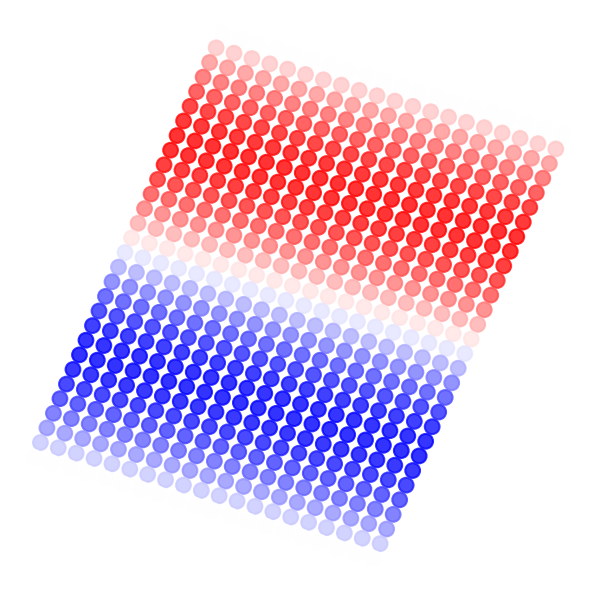

/Users/mikichan/miniconda3/envs/dGSP/lib/python3.8/site-packages/matplotlib/axes/_axes.py:4405: ComplexWarning: Casting complex values to real discards the imaginary part
  c = np.asanyarray(c, dtype=float)


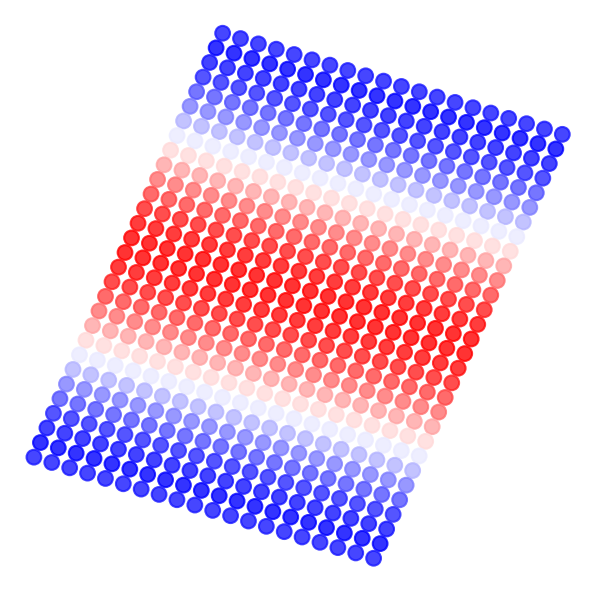

In [31]:
graphsig = np.sin(coords[:, 1]/coords[:, 1].max() * 2 * np.pi)
xa = operations.analytical_signal(graphsig, U, V, Uinv=Uinv)
hx = operations.hilbert_transform(graphsig, U, V, Uinv=Uinv)
amp = np.abs(xa)
ang = np.arctan2(xa.imag, xa.real)

fig, ax = plt.subplots(1, figsize=(5, 5))
nx.draw_networkx_nodes(G, rotpos, alpha=0.8, node_size=50, node_color=graphsig, cmap="bwr", ax=ax)

ax.axis('off')
plt.show()

fig, ax = plt.subplots(1, figsize=(5, 5))

nx.draw_networkx_nodes(G, rotpos, alpha=0.8, node_size=50, node_color=hx, cmap="bwr", ax=ax)
ax.axis('off')
plt.show()

### Fig 3: Manhattan Graph

In [32]:
# Notebook specific imports / functions
import osmnx as ox

def spatial_smooth(signal, coords, size=1e-3):
    """
    Applies spatial smoothing to a signal based on given coordinates.

    Parameters
    ----------
    signal : array-like
        The input signal to be smoothed.
    coords : array-like
        The coordinates corresponding to each point in the signal.
    size : float, optional
        The smoothing size parameter. Points within this distance from each other
        will be averaged. Default is 1e-3.

    Returns
    -------
    array-like
        The smoothed signal.
    """
    ret = deepcopy(signal)
    if size <= 0:
        return ret
    for k in range(len(coords)):
        ret[k] = ret[np.linalg.norm(coords[k] - coords, axis=1) < size].mean()
    return ret

In [41]:
from shapely import Polygon
from shapely.geometry import Point

# Get Graph
if op.exists(op.join(path_data, 'manhattan_graph/manhattan_graph.pkl')):
    graph_info = load(op.join(path_data, 'manhattan_graph/manhattan_graph.pkl'))
    adj = graph_info['adj']
    nodes_coords = graph_info['nodes_coords']
    graphnodes = graph_info['graphnodes']
    graph = graph_info['graph']
    pos = graph_info['pos']
    G = graph_info['G']
    
else:
    coords = ((-73.958759, 40.727877), (-74.013777, 40.74), 
            (-74.005, 40.772677), (-73.958759, 40.765))

    polygon = Polygon(coords)

    place = ox.graph_from_polygon(polygon, network_type='drive')
    graph = ox.project_graph(place)
    graphnodes = np.array(graph)

    nodes_coords = np.array([(graph.nodes[graphnodes[k]]["lon"], graph.nodes[graphnodes[k]]["lat"]) for k in range(len(graphnodes))])

    adj = nx.convert_matrix.to_numpy_array(graph)
    G = nx.from_numpy_array(adj, create_using=nx.MultiDiGraph())
    pos = {k: nodes_coords[k] for k in range(len(G.nodes))}

    fig,ax = plt.subplots(1, figsize=(7,7))
    nx.draw_networkx(G, pos,alpha=0.3,width=1,with_labels=False,node_size=1,
                    edge_color="blue",node_color=np.zeros((len(G))),cmap="hot", ax=ax)

    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax.set_title('Midtown Manhattan Network')

    graph_info = {'adj': adj, 'nodes_coords': nodes_coords, 'graphnodes': graphnodes,
                  'graph': graph, 'pos': pos, 'G': G}
    save(op.join(path_data, 'manhattan_graph/manhattan_graph.pkl'), graph_info)

# Get directionalities
tmp = nodes_coords[np.argsort(nodes_coords[:,1])]
tmpselect = [-10, -16]

coefficients = np.polyfit(tmp[tmpselect][:,0], tmp[tmpselect][:,1], 1)
polynomial = np.poly1d(coefficients)
polynomial_vertical = np.poly1d(coefficients)

frequency_vertical = 200
frequency_horizontal = 600
manifold_vertical = np.sin(np.sort(nodes_coords[:,0]) * frequency_vertical)
manifold_horizontal = np.sin(np.sort(nodes_coords[:,1]) * frequency_horizontal)
graph_signal = np.zeros_like(manifold_vertical)

ycoords_rank = np.argsort(nodes_coords[:,0])
xcoords_rank = np.argsort(nodes_coords[:,1])

# we order the coordinates by a certain direction
direction_vector = np.array([1, polynomial_vertical[1]*2])
direction_vector2 = np.array([-polynomial_vertical[1], 1])

ranking_vector = (nodes_coords @ direction_vector)
ranking_vector2 = (nodes_coords @ direction_vector2)
xycoords_rank = np.argsort(ranking_vector)
xycoords_rank2 = np.argsort(ranking_vector2)
frequency_vertdiagonal = 1
frequency_horidiagonal = 1.5
manifold_vertdiagonal = np.sin(np.sort(zscore(ranking_vector)) * frequency_vertdiagonal)
manifold_horizdiagonal = np.sin(np.sort(zscore(ranking_vector2)) * frequency_horidiagonal)

manifold_vertdiagonalpi2 = np.sin(np.sort(zscore(ranking_vector)) * frequency_vertdiagonal + np.pi/2)
manifold_horizdiagonalpi2 = np.sin(np.sort(zscore(ranking_vector2)) * frequency_horidiagonal + np.pi/2)

graph_signal[xycoords_rank] += manifold_vertdiagonal

Graph analysis

In [40]:
newA = load(op.join(path_data, 'manhattan_graph/midmanhattan_graph_nopref.pkl'))

G_diag = nx.from_numpy_array(newA, create_using=nx.MultiDiGraph())
_, Ua, Va, Uinva, _, _, _ = graph_utils.prep_transform(newA, gso="adj")

Method chosen is: eig


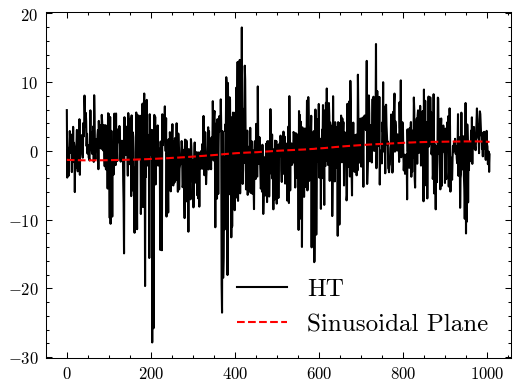

In [42]:
hx = operations.hilbert_transform(graph_signal, Ua, Va, Uinv=Uinva)

# Modify the following line to change the direction of the signal
coords_ordering = xycoords_rank

fig, ax = plt.subplots(1, figsize=(4,3))
smoothened_ht = np.zeros_like(graph_signal)

smoothened_ht[xycoords_rank] = hx.real[xycoords_rank]

zscore_graphsignal = np.zeros_like(graph_signal)
zscore_graphsignal[coords_ordering] = zscore(graph_signal[coords_ordering])
ax.plot(smoothened_ht[coords_ordering], label='HT')
ax.plot(zscore_graphsignal[coords_ordering], label='Sinusoidal Plane')
ax.legend(prop={'size':12})
plt.show()

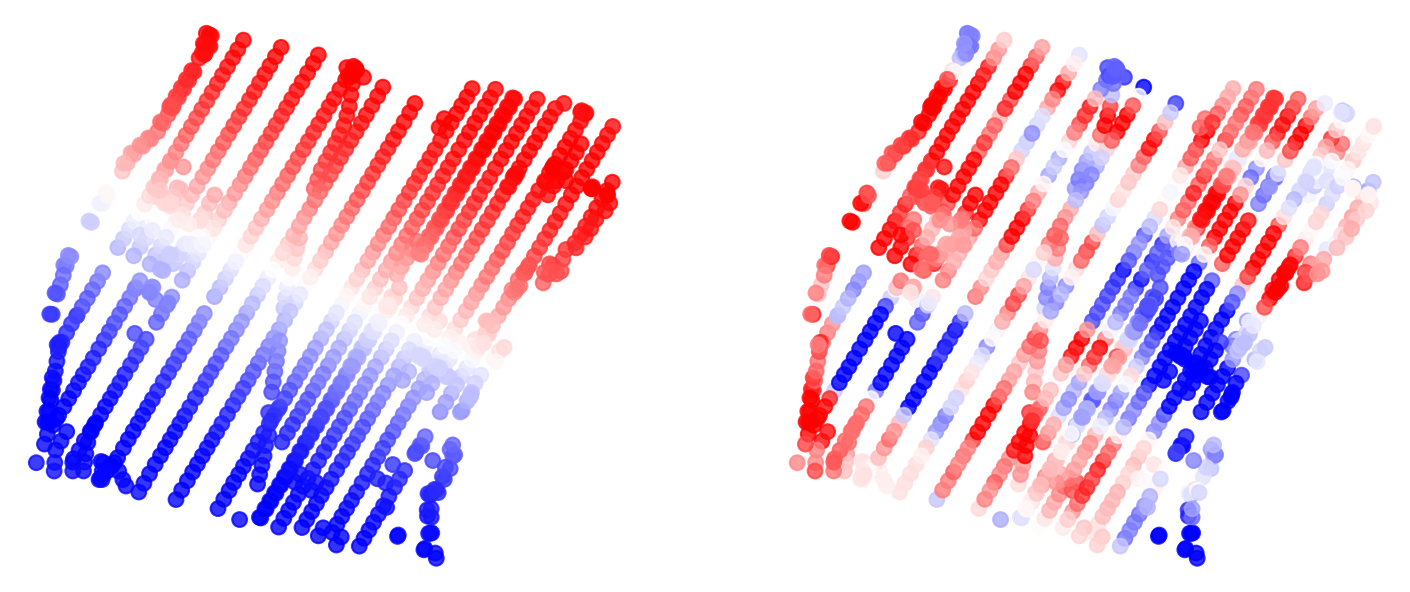

In [43]:
ssize = 2e-3
display_ht = spatial_smooth(smoothened_ht, nodes_coords, ssize)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

nx.draw_networkx_nodes(G,pos,alpha=0.8,node_size=50,
                            node_color=graph_signal, cmap="bwr", ax=ax[0])
nx.draw_networkx_nodes(G,pos,alpha=0.8,node_size=50,
                            node_color=display_ht, cmap="bwr", ax=ax[1], 
                            vmin=np.percentile(display_ht, 10), vmax=np.percentile(display_ht, 90))

ax[0].set_axis_off()
ax[1].set_axis_off()

plt.show()